<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

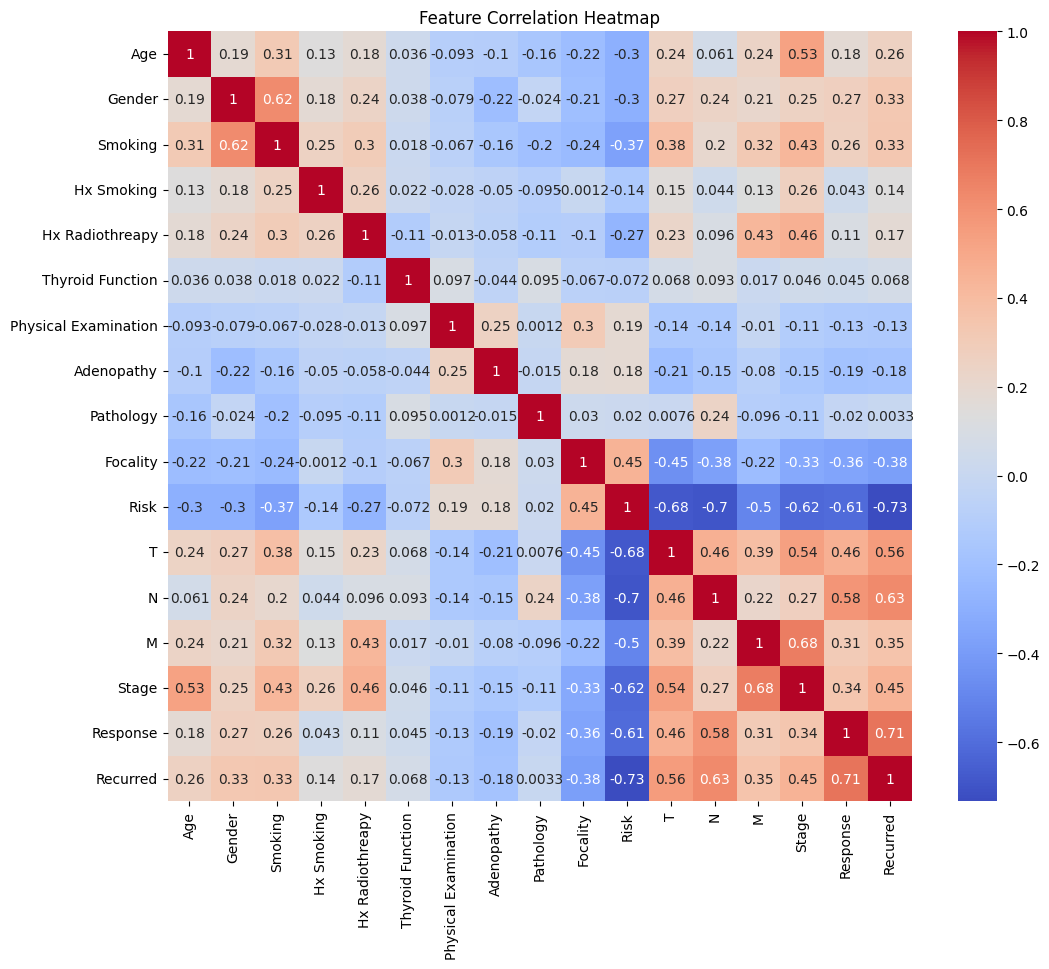

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        55
           1       1.00      0.86      0.93        22

    accuracy                           0.96        77
   macro avg       0.97      0.93      0.95        77
weighted avg       0.96      0.96      0.96        77

ROC AUC: 0.9867768595041322
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77

ROC AUC: 0.9900826446280991


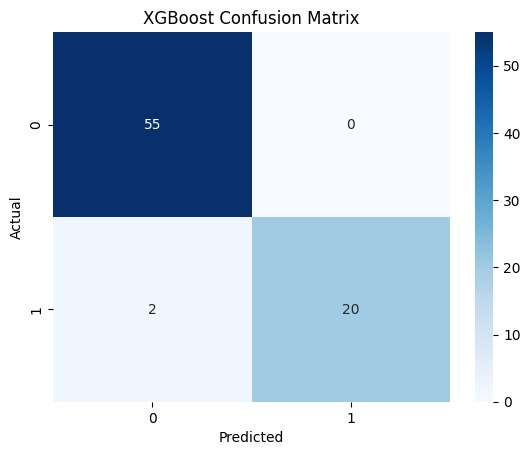

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77

ROC AUC: 0.9900826446280991


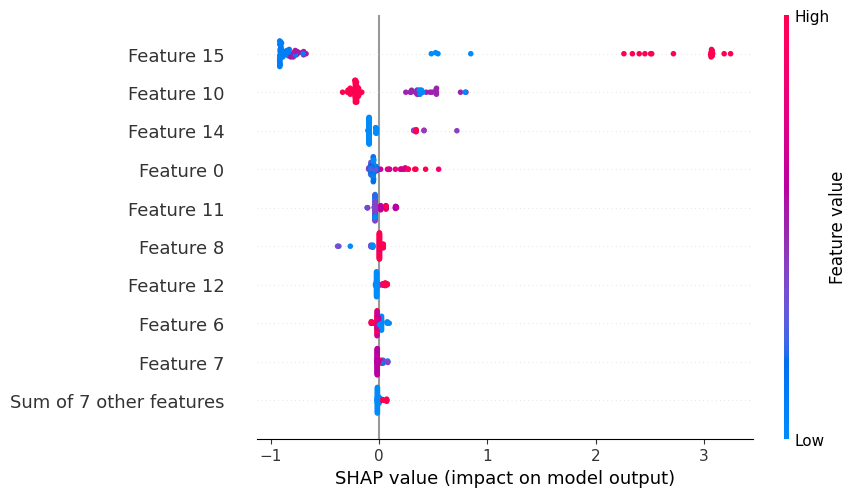

Model saved as thyroid_recurrence_model_tuned_xgb.pkl


In [1]:

# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# 📁 Load the Dataset
df = pd.read_csv("/content/dataset.csv")
df.head()

# 🔍 Basic Info
print(df.info())
print(df.describe())
print(df.isnull().sum())

# 🔢 Encode Categorical Features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 📊 Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# 🧹 Features and Target
X = df.drop("Recurred", axis=1)
y = df["Recurred"]

# ✂️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ⚙️ Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 🌳 Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# 🚀 XGBoost Model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# 🎯 Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# 🧪 GridSearchCV - Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
xgb_preds = best_xgb.predict(X_test)
print("Tuned XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

# 🔬 SHAP Explainability
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)

# Beeswarm Plot
shap.plots.beeswarm(shap_values)

# 💾 Save the Tuned Model
joblib.dump(best_xgb, "thyroid_recurrence_model_tuned_xgb.pkl")
print("Model saved as thyroid_recurrence_model_tuned_xgb.pkl")